# Import package 

In [1]:
import os
import cv2
import time
# import wandb
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

2024-10-27 12:56:33.808580: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-27 12:56:33.833028: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-27 12:56:33.833060: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-27 12:56:33.847978: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-27 12:56:34.793786: W tensorflow/com

In [2]:
import boto3
import sagemaker
from sagemaker.session import Session
from sagemaker import get_execution_role
from sagemaker.tuner import CategoricalParameter, ContinuousParameter, HyperparameterTuner
from sagemaker.tensorflow import TensorFlow
from sagemaker.debugger import Rule, DebuggerHookConfig, TensorBoardOutputConfig, CollectionConfig, ProfilerRule, rule_configs, ProfilerConfig, FrameworkProfile
from sagemaker.analytics import HyperparameterTuningJobAnalytics


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


# Handle Data

## Define DataLoader

In [18]:
class CustomDataLoader:
    def __init__(self, bucket_name, data_dir, image_size=(256,256), 
                 batch_size=8, buffer_size=500, images_train=0):
        self.s3 = boto3.client('s3')
        self.bucket_name = bucket_name
        self.data_dir = data_dir  # This will be the S3 prefix
        self.dir_train, self.dir_val, self.dir_test = self.dir_train_test_validation()
        
        self.image_size = image_size
        self.batch_size = batch_size
        self.buffer_size = buffer_size
        self.images_train = images_train
        # self.images_valid_test = int(self.images_train*10%) if self.images_train>10 else
        self.trainsets = None
        self.valsets = None
        self.testsets = None
    
    def dir_train_test_validation(self):
        dir_train = os.path.join(self.data_dir, "train")
        dir_val = os.path.join(self.data_dir, "validation")
        dir_test = os.path.join(self.data_dir, "test")
        return dir_train, dir_val, dir_test
        
    def dir_folder_mask_unmask(self, dir_datasets):
        dir_folder_unmask = os.path.join(dir_datasets, "un_mask")
        dir_folder_masked = os.path.join(dir_datasets, "mask")
        print(dir_folder_unmask, dir_folder_masked)
        return dir_folder_unmask, dir_folder_masked
    
    def list_s3_files(self, prefix):
        response = self.s3.list_objects_v2(Bucket=self.bucket_name, Prefix=prefix)
        if 'Contents' in response:
            return [content['Key'] for content in response['Contents']]
        return []
    
    def get_images(self, dir_mask, dir_unmask, data_test=False):
        maskes = []
        unmaskes = []

        # Retrieve the list of images from S3
        mask_files = self.list_s3_files(dir_mask)
        unmask_files = self.list_s3_files(dir_unmask)

        # Match files based on your logic
        for path_img_unmask in unmask_files:
            base_name_unmask = os.path.basename(path_img_unmask).split('.')[0]
            for path_img_mask in mask_files:
                # print(base_name_unmask, os.path.basename(name_mask).split(".")[0])
                if os.path.basename(path_img_mask).split(".")[0].split('_')[0] == base_name_unmask:
                    mask_imge, unmask_image = self.load_image(mask_path=path_img_mask, 
                                                              unmask_path=path_img_unmask)
                    maskes.append(mask_imge)
                    unmaskes.append(unmask_image)
            if not data_test and self.images_train>0 and len(maskes)==self.images_train:
                break
            elif data_test and self.images_train>0 and len(maskes)==int(self.images_train*10/100):
                break

        print(f"Number image mask: {len(maskes)} - Num image unmask: {len(unmaskes)}")
        return maskes, unmaskes
    
    def resize_image(self, image_mask, image_unmask):
        image_mask = tf.image.resize(image_mask, self.image_size, method= 'bilinear')
        image_unmask = tf.image.resize(image_unmask, self.image_size, method= 'bilinear')
        return image_mask, image_unmask
    
    def normalize_image(self, image_mask, image_unmask):
        image_mask = tf.cast(image_mask, tf.float32)
        image_unmask = tf.cast(image_unmask, tf.float32)
        image_mask = (image_mask / 127.5) - 1
        image_unmask = (image_unmask / 127.5) - 1

        return image_mask, image_unmask
    
    def load_image(self, mask_path, unmask_path):
        image_mask = self.read_image_from_s3(object_key=mask_path)
        image_unmask = self.read_image_from_s3(object_key=unmask_path)
        image_mask, image_unmask = self.normalize_image(image_mask=image_mask, image_unmask=image_unmask)
        image_mask, image_unmask = self.resize_image(image_mask=image_mask, image_unmask=image_unmask)
        return image_mask, image_unmask
    
    def read_image_from_s3(self, object_key):
        # Download the image as a stream of bytes
        response = self.s3.get_object(Bucket=self.bucket_name, Key=object_key)
        img_data = response['Body'].read()
        # Decode the image using TensorFlow
        img = tf.io.decode_image(img_data, channels=3)
        return img

    def load_trainsets(self):
        dir_train_unmask, dir_train_mask = self.dir_folder_mask_unmask(dir_datasets=self.dir_train)
        
        mask_images, unmask_images = self.get_images(dir_mask=dir_train_mask, dir_unmask=dir_train_unmask, data_test=False)
        print(f"Number train image: {len(mask_images)}")
        self.trainsets = tf.data.Dataset.from_tensor_slices((mask_images, unmask_images)).prefetch(tf.data.AUTOTUNE) \
                        .shuffle(buffer_size=self.buffer_size).batch(self.batch_size)
    
    def load_valsets(self):
        dir_val_unmask, dir_val_mask = self.dir_folder_mask_unmask(dir_datasets=self.dir_val)
        mask_images, unmask_images = self.get_images(dir_mask=dir_val_mask, dir_unmask=dir_val_unmask, data_test=True)

        print(f"Number validation image: {len(mask_images)}")

       
        self.valsets = tf.data.Dataset.from_tensor_slices((mask_images, unmask_images)).prefetch(tf.data.AUTOTUNE) \
                        .shuffle(buffer_size=self.buffer_size).batch(self.batch_size)
    def load_testsets(self):
        dir_test_unmask, dir_test_mask = self.dir_folder_mask_unmask(dir_datasets=self.dir_test)
        mask_images, unmask_images = self.get_images(dir_mask=dir_test_mask, dir_unmask=dir_test_unmask, data_test=True)

        print(f"Number test image: {len(mask_images)}")

       
        self.testsets = tf.data.Dataset.from_tensor_slices((mask_images, unmask_images)). \
            prefetch(tf.data.AUTOTUNE).batch(self.batch_size)

    def load_data_set(self, folder_data="test"):
        if folder_data.lower() == "train":
            if self.trainsets is None:
                self.load_trainsets()
            return self.trainsets
        elif folder_data == "validation":
            if self.valsets is None:
                self.load_valsets()
            return self.trainsets
        else:
            if self.testsets is None:
                self.load_testsets()
            return self.testsets

    def load(self):
        self.load_trainsets()
        self.load_valsets()
        self.load_testsets()
        return self.trainsets, self.valsets, self.testsets

In [ ]:
def generate_images(model, test_input, tar):
  prediction = model(test_input, training=True)
  plt.figure(figsize=(15, 15))

  display_list = [test_input[0]*0.5 + 0.5, tar[0]*0.5 + 0.5, prediction[0]*0.5 + 0.5]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # Getting the pixel values in the [0, 1] range to plot.
    plt.imshow(display_list[i])
    plt.axis('off')
  plt.show()

## Load Data

In [36]:
#Change bucket_name and data_dir with your use case
mydataloader =  CustomDataLoader(bucket_name="aws-ml-mycapstone-project", data_dir="dataset-try")
train_datasets, valid_sets, test_datasets = mydataloader.load()

dataset-try/test/un_mask dataset-try/test/mask
dataset-try/validation/un_mask dataset-try/validation/mask
dataset-try/test/un_mask dataset-try/test/mask


2024-10-27 13:01:50.017607: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


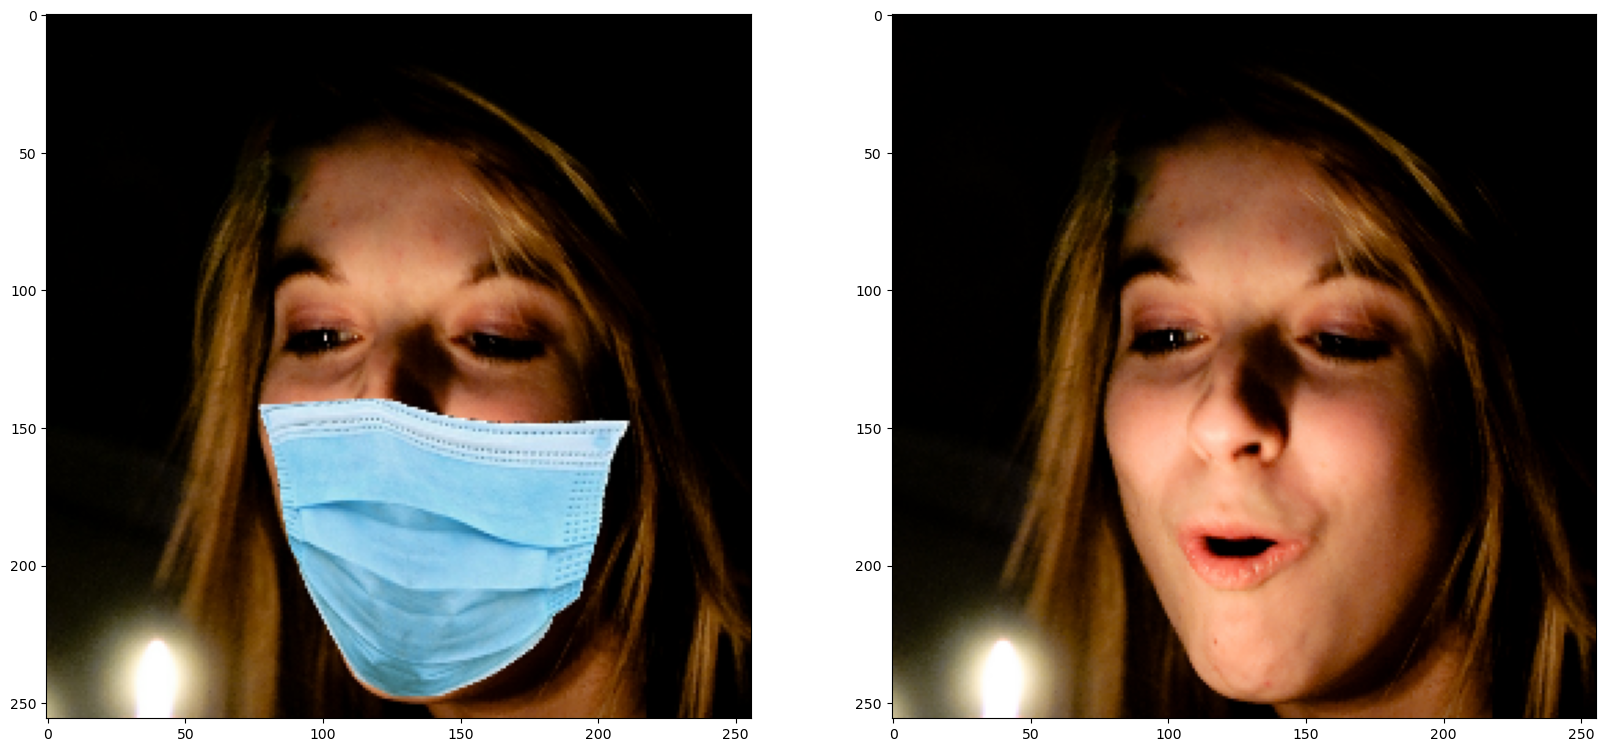

In [21]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize= (20, 20))
for image, mask in train_datasets.take(1):
    # print(type(image))
    plt.subplot(1, 2, 1)
    plt.imshow(image[0]*0.5 + 0.5)

    plt.subplot(1, 2, 2)
    plt.imshow(mask[0]*0.5 + 0.5)

2024-10-27 13:02:00.154805: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


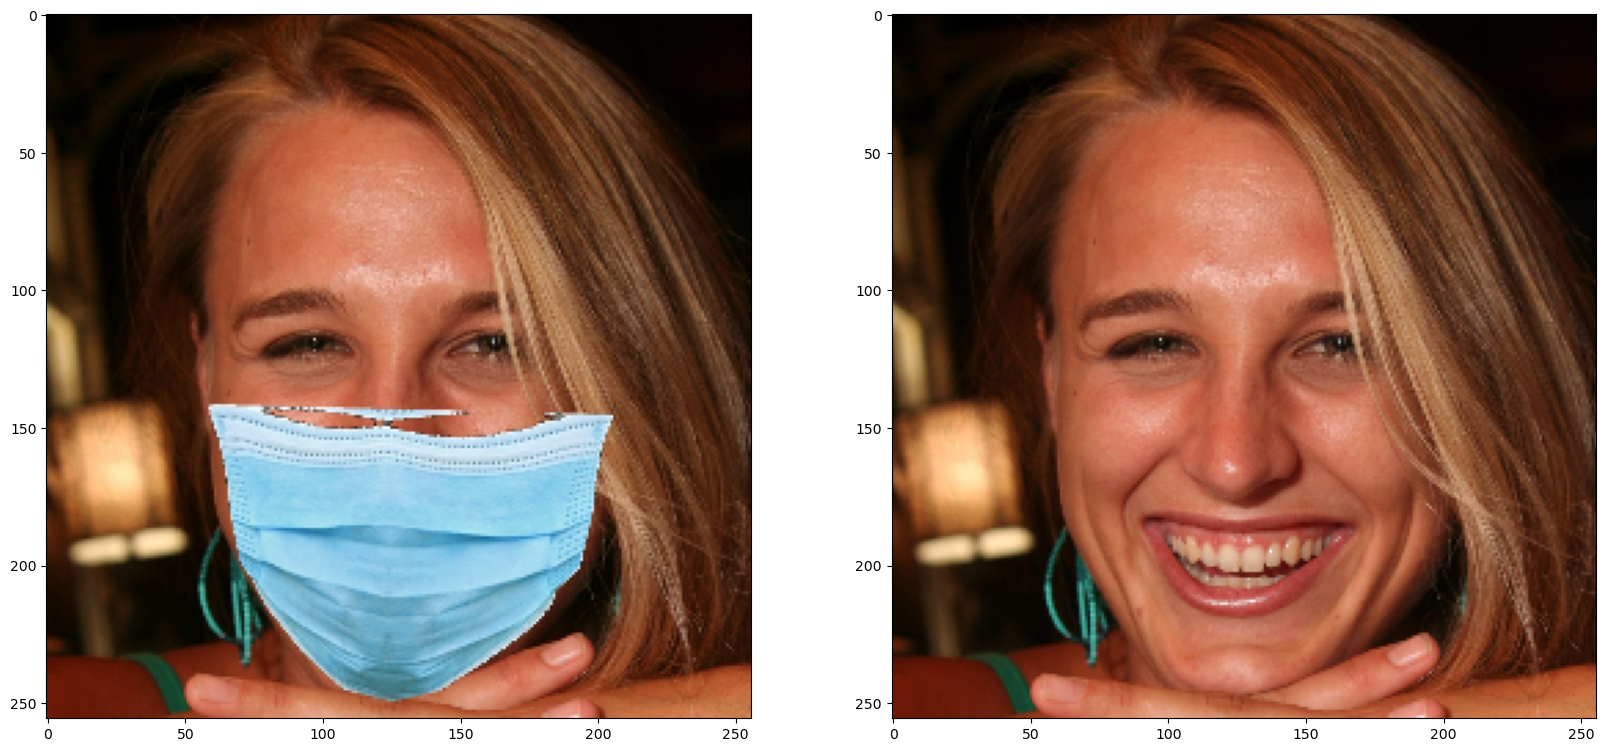

In [22]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20, 20))
for image, mask in test_datasets.take(1):
    # print(type(image))
    plt.subplot(1, 2, 1)
    plt.imshow(image[0]*0.5 + 0.5)

    plt.subplot(1, 2, 2)
    plt.imshow(mask[0]*0.5 + 0.5)

2024-10-27 13:21:43.332168: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


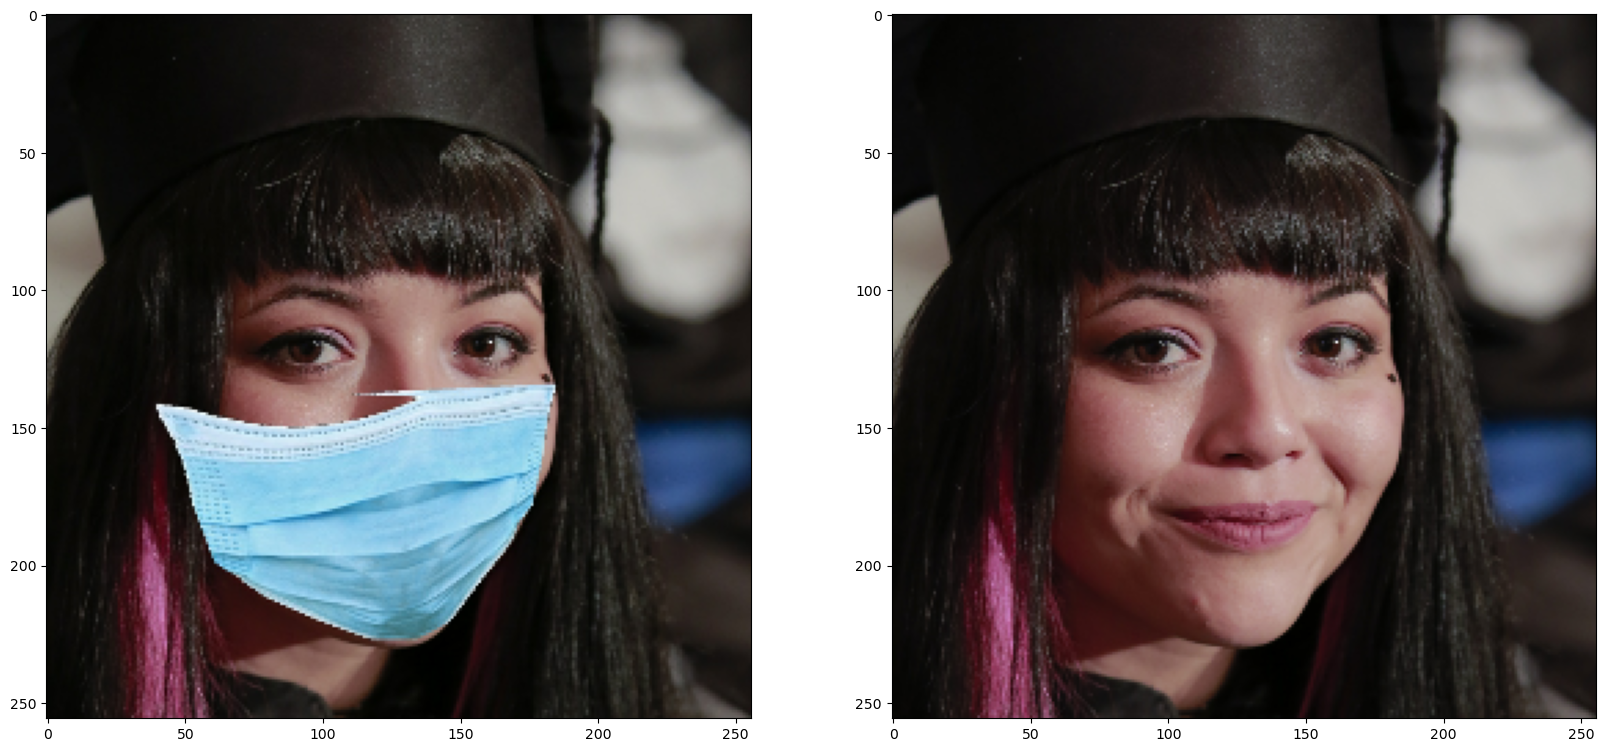

In [37]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize= (20, 20))
for image, mask in test_datasets.take(1):
    # print(type(image))
    plt.subplot(1, 2, 1)
    plt.imshow(image[0]*0.5 + 0.5)

    plt.subplot(1, 2, 2)
    plt.imshow(mask[0]*0.5 + 0.5)

# Model initialization

## Define Class

In [ ]:

import tensorflow as tf
from tensorflow import keras

class spatial_attention(tf.keras.layers.Layer):
    """ spatial attention module 
        
    Contains the implementation of Convolutional Block Attention Module(CBAM) block.
    As described in https://arxiv.org/abs/1807.06521.
    """
    def __init__(self, kernel_size=7, trainable=True ,**kwargs):
        self.kernel_size = kernel_size
        super(spatial_attention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.conv3d = tf.keras.layers.Conv2D(filters=1, 
                                             kernel_size=self.kernel_size,
                                             strides=1, 
                                             padding='same', 
                                             activation='sigmoid',
                                             kernel_initializer='he_normal', 
                                             use_bias=False)
        super(spatial_attention, self).build(input_shape)

    def compute_output_shape(self, input_shape):
        return input_shape

    def call(self, inputs):
        avg_pool = tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x, axis=-1, keepdims=True))(inputs)
        max_pool = tf.keras.layers.Lambda(lambda x: tf.keras.backend.max(x, axis=-1, keepdims=True))(inputs)
        concat = tf.keras.layers.Concatenate(axis=-1)([avg_pool, max_pool])
        feature = self.conv3d(concat)
        multiplied = tf.keras.layers.Multiply()([inputs, feature])
        # shape_out = multiplied.shape
        # return tf.keras.layers.multiply()([inputs, feature])
        return multiplied
    

class Attention_map(tf.keras.layers.Layer):
    """ 
    Attention module
    As described in: https://arxiv.org/pdf/2112.01098.pdf
    """ 
    def __init__(self,num_filters, trainable=True, **kwargs):
        self.num_filters = num_filters
        self.initializer = tf.random_normal_initializer(0., 0.02)

        self.conv4a = tf.keras.layers.Conv2D(4*self.num_filters, 
                                            kernel_size=3,
                                            padding="same")

        self.conv8 = tf.keras.layers.Conv2D(8*self.num_filters, 
                                            kernel_size=3,
                                            padding="same")

        self.conv4b = tf.keras.layers.Conv2D(4*self.num_filters, 
                                            kernel_size=3,
                                            padding="same")

        self.conv2 = tf.keras.layers.Conv2D(2*self.num_filters, 
                                            kernel_size=3,
                                            padding="same") 

        super(Attention_map,self).__init__(**kwargs)

    def call(self, inputs, training, **kwargs):
        x = self.conv4a(inputs)
        x = self.conv8(x)
        x = self.conv4b(x)
        x = self.conv2(x)
        return x

    
def compute_fused(fenc, fdec, name_layer, trainable=True):
    """
    Compute fused module \n
    f_fused = fenc*Attention_map[0] + fdec*Attention_map[1]
    """
    fconcat =  tf.concat([fenc, fdec], 0)
    output_attentionmap = Attention_map(num_filters=64,trainable=trainable, name=name_layer)(fconcat)
    f_fused = fenc*output_attentionmap[0] + fdec*output_attentionmap[1]
    return f_fused

class Residual_Block(keras.layers.Layer):
    """
    Residual Block from ResNet:
    Input: (2H,2W,C) => Ouput: (H,W,C')
    """
    def __init__(self, num_filter, kernel_size=3, trainable=True,  **kwargs):
        super(Residual_Block, self).__init__(**kwargs)
        self.filters= num_filter
        self.kernel_size = kernel_size
        self.trainable = trainable

    def build(self, input_shape):
        self.x_skip = tf.keras.layers.Conv2D(self.filters,
                                             kernel_size=1,
                                             padding="same")

        self.conv2a = tf.keras.layers.Conv2D(self.filters, 
                                             kernel_size=self.kernel_size, 
                                             padding='same')
        self.bn2a = tf.keras.layers.BatchNormalization()

        self.conv2b = tf.keras.layers.Conv2D(filters=self.filters, 
                                             kernel_size=self.kernel_size,
                                             padding='same')
        self.bn2b = tf.keras.layers.BatchNormalization()
        super(Residual_Block, self).build(input_shape)

    def compute_output_shape(self, input_shape):
        return input_shape

    def call(self, inputs):
        x_skip = self.conv2a(inputs)

        x = self.conv2a(inputs)
        x = self.bn2a(x,self.trainable)
        out1 = tf.nn.relu(x)

        out2 = self.conv2b(out1)
        out2 = self.bn2b(out2,self.trainable)
        out2 = tf.nn.relu(out2)


        add = tf.keras.layers.Add()([x_skip, out2])
        out = tf.nn.relu(add)
        return out


class Decoder_Block(tf.keras.layers.Layer):
    """
    Decoder Block: Upsampling and Residual Block 
    Input: (H,W, 2C) => Ouput: (2H,2W, C)
    """
    def __init__(self,num_filter, kernel_size=3, trainable=True, **kwargs):
        super(Decoder_Block, self).__init__(**kwargs)
        self.num_filter = num_filter
        self.kernel_size = kernel_size
        self.residual = Residual_Block(num_filter=self.num_filter, 
                                       kernel_size=self.kernel_size)
        self.upsampling = tf.keras.layers.Conv2DTranspose(filters=self.num_filter,
                                                          kernel_size=2,
                                                          strides=2)
    def call(self, inputs, **kwargs):
        x = self.upsampling(inputs)
        x = self.residual(x)
        return x

class Ouput_layer(tf.keras.layers.Layer):
    """
    Output layer of model with shape (H,W,3)
    """
    def __init__(self, trainable=True, **kwargs):
        super(Ouput_layer, self).__init__(**kwargs)
        self.conv2d = tf.keras.layers.Conv2D(filters=3,
                                             kernel_size=3,
                                             padding="same")
        self.bn2d = tf.keras.layers.BatchNormalization()

    def call(self, inputs, **kwargs):
        output = self.conv2d(inputs)
        output = self.bn2d(output)
        output = tf.nn.relu(output)
        return output

def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

## Model Generator

In [30]:
def Generator(shape=(256,256,3), train_attention=True):
    x_input = tf.keras.layers.Input(shape=shape, name='Input_layer')

    encoder0 = Residual_Block(num_filter=32, kernel_size=3, name="Encoder_0")(x_input)
    encoder0 = tf.keras.layers.MaxPooling2D((2, 2), name="MaxPooling2D_0")(encoder0)

    encoder1 = Residual_Block(num_filter=64, kernel_size=3, name="Encoder_1")(encoder0)
    encoder1 = tf.keras.layers.MaxPooling2D((2, 2), name="MaxPooling2D_1")(encoder1)
    
    encoder2 = Residual_Block(num_filter=128, kernel_size=3, name="Encoder_2")(encoder1)
    maxpooling_2 = tf.keras.layers.MaxPooling2D((2, 2), name="MaxPooling2D_2")(encoder2)

    encoder3 = Residual_Block(num_filter=256, kernel_size=3, name="Encoder_3")(maxpooling_2)
    encoder3 = tf.keras.layers.MaxPooling2D((2, 2), name="MaxPooling2D_3")(encoder3)

    encoder4 = Residual_Block(num_filter=512, kernel_size=3, name="Encoder_4")(encoder3)
    encoder4 = tf.keras.layers.MaxPooling2D((2, 2), name="MaxPooling2D_4")(encoder4)

    bottleneck = tf.keras.layers.Conv2D(1024, 3, padding="same", name="bottleneck")(encoder4)

    decoder0 = Decoder_Block(num_filter=512, kernel_size=3, name="Decoder_0")(bottleneck)
    decoder1 = Decoder_Block(num_filter=256, kernel_size=3, name="Decoder_1")(decoder0)
    decoder2 = Decoder_Block(num_filter=128, kernel_size=3, name="Decoder_2")(decoder1)
    if train_attention:
        f_enc = spatial_attention(trainable=train_attention, name="F_enc")(encoder2)
        f_dec = spatial_attention(trainable=train_attention, name="F_dec")(decoder2)
        f_fused = compute_fused(f_enc, f_dec, trainable=train_attention, name_layer="Attention_map")
        input_decoder3 = tf.keras.layers.Add(name="Add_f_fused")([decoder2, f_fused])
        decoder3 = Decoder_Block(num_filter=64, kernel_size=3, name="Decoder_3")(input_decoder3)
        
    else:
        decoder3 = Decoder_Block(num_filter=64, kernel_size=3, name="Decoder_3")(decoder2)
    decoder4 = Decoder_Block(num_filter=32, kernel_size=3, name="Decoder_4")(decoder3)

    imageout = Ouput_layer(name="Ouput_layer")(decoder4)

    mymodel = tf.keras.Model(inputs=x_input, outputs=imageout, name="Generator")
    return mymodel

In [33]:
generator = Generator(train_attention=True)
generator.summary()

Model: "Generator"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Input_layer (InputLayer)    [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 Encoder_0 (Residual_Block)  (None, 256, 256, 32)         10400     ['Input_layer[0][0]']         
                                                                                                  
 MaxPooling2D_0 (MaxPooling  (None, 128, 128, 32)         0         ['Encoder_0[0][0]']           
 2D)                                                                                              
                                                                                                  
 Encoder_1 (Residual_Block)  (None, 128, 128, 64)         55936     ['MaxPooling2D_0[0][0]

## Model Discriminator

In [ ]:
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
  tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')

  x = tf.keras.layers.concatenate([inp, tar])  # (e, 256, 256, channels*2)batch_siz

  down1 = downsample(64, 4, False)(x)  # (batch_size, 128, 128, 64)
  down2 = downsample(128, 4)(down1)  # (batch_size, 64, 64, 128)
  down3 = downsample(256, 4)(down2)  # (batch_size, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (batch_size, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1)  # (batch_size, 31, 31, 512)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (batch_size, 33, 33, 512)

  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2)  # (batch_size, 30, 30, 1)

  return tf.keras.Model(inputs=[inp, tar], outputs=last)


In [32]:
discriminator = Discriminator()
discriminator.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_image (InputLayer)    [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 target_image (InputLayer)   [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 concatenate (Concatenate)   (None, 256, 256, 6)          0         ['input_image[0][0]',         
                                                                     'target_image[0][0]']        
                                                                                                  
 sequential (Sequential)     (None, 128, 128, 64)         6144      ['concatenate[0][0]']     

In [ ]:
role = get_execution_role()
sagemaker_session = sagemaker.Session()

# **Config Loss**

In [42]:
def discriminator_loss(real_image, fake_image):
    cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True, label_smoothing=0.1)
    
    real_loss = cross_entropy(tf.ones_like(real_image), real_image)
    fake_loss = cross_entropy(tf.zeros_like(fake_image), fake_image)
    total_loss = real_loss + fake_loss
    return total_loss

def loss_SSIM(target_image, gen_image):
    ssim = tf.image.ssim(target_image, gen_image, max_val=1.0, filter_size=11,
                          filter_sigma=1.5, k1=0.01, k2=0.03)
    return (1-ssim)


def generator_loss(target_image, gen_image):
    mae = tf.keras.losses.MeanAbsoluteError(reduction=tf.keras.losses.Reduction.SUM_OVER_BATCH_SIZE)

    #Loss SSIM
    l_ssim = tf.reduce_mean(loss_SSIM(target_image, gen_image))
    
    #Loss Recontruction
    l_rec = mae(target_image, gen_image)
    return l_ssim, l_rec

# **Train Step**

In [38]:
!mkdir path_to_save_checkpoint

In [39]:
#Config optimizers and learning rate
generator_optimizer = tf.keras.optimizers.Adam(1e-5, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(9e-6, beta_1=0.5)

lambda_rec = 1.2
lambda_adv = 0.5
lambda_ssim = 80


In [ ]:
checkpoint_dir = "path_to_save_checkpoint"
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)
log_dir="logs/"

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [59]:
def evaluate_val(valid_dataset, model_information, hyper_params):
    loss_total_each_batch=[]
    loss_ssim_each_batch=[]
    loss_rec_each_batch=[]
    disc_loss_each_batch=[]
    
    generator = model_information["generator"]
    discriminator = model_information["discriminator"]
    
    lambda_rec = hyper_params["lambda_rec"]
    lambda_adv = hyper_params["lambda_adv"]
    lambda_ssim = hyper_params["lambda_ssim"]
    
    for step, (batch_test_image, batch_test_target) in enumerate(valid_dataset):
        valid_out = generator(batch_test_image, training=True)
        val_ssim_loss,  val_rec_loss = generator_loss(batch_test_target, valid_out)
        loss_ssim_each_batch.append(val_ssim_loss)
        loss_rec_each_batch.append(val_rec_loss)

        disc_real_output  = discriminator([batch_test_image, batch_test_target], training=True)
        disc_generated_output  = discriminator([batch_test_image, valid_out], training=True)

        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)
        loss_total = lambda_rec*val_rec_loss + lambda_adv*disc_loss + lambda_ssim*val_ssim_loss

        loss_total_each_batch.append(loss_total)
        disc_loss_each_batch.append(disc_loss)
    eval_results = {"loss_total_each_batch": np.mean(loss_total_each_batch),
                    "loss_ssim_each_batch": np.mean(loss_ssim_each_batch),
                    "loss_rec_each_batch": np.mean(loss_rec_each_batch),
                    "disc_loss_each_batch": np.mean(disc_loss_each_batch),}
    return eval_results


def train_step(train_datasets, update_D, model_information, hyper_params):
    loss_total_each_batch=[]
    loss_ssim_each_batch=[]
    loss_rec_each_batch=[]
    disc_loss_each_batch=[]
    
    lambda_rec = hyper_params["lambda_rec"]
    lambda_adv = hyper_params["lambda_adv"]
    lambda_ssim = hyper_params["lambda_ssim"]
    
    generator = model_information["generator"]
    generator_optimizer = model_information["generator_optimizer"]
    discriminator = model_information["discriminator"]
    discriminator_optimizer = model_information["discriminator_optimizer"]
    
    for step, (batch_train_image, batch_train_target) in enumerate(train_datasets):
        print(f"Batch: {step+1}...", end='\r')
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            gen_out = generator(batch_train_image, training=True)
            gen_ssim_loss,  gen_rec_loss = generator_loss(batch_train_target, gen_out)
            loss_ssim_each_batch.append(gen_ssim_loss)
            loss_rec_each_batch.append(gen_rec_loss)

            disc_real_output = discriminator([batch_train_image, batch_train_target], training=True)
            disc_generated_output = discriminator([batch_train_image, gen_out], training=True)

            disc_loss = discriminator_loss(disc_real_output, disc_generated_output)
            loss_total = lambda_rec*gen_rec_loss + lambda_adv*disc_loss + lambda_ssim*gen_ssim_loss

            loss_total_each_batch.append(loss_total)
            disc_loss_each_batch.append(disc_loss)

        generator_gradients = gen_tape.gradient(loss_total,
                                    generator.trainable_variables)
        generator_optimizer.apply_gradients(zip(generator_gradients,
                                        generator.trainable_variables))
    
        if update_D:
            discriminator_gradients = disc_tape.gradient(disc_loss,
                                                discriminator.trainable_variables)
            discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                                discriminator.trainable_variables))
    train_results = {"loss_total_each_batch": np.mean(loss_total_each_batch),
                    "loss_ssim_each_batch": np.mean(loss_ssim_each_batch),
                    "loss_rec_each_batch": np.mean(loss_rec_each_batch),
                    "disc_loss_each_batch": np.mean(disc_loss_each_batch),}
    
    model_info = {"generator": generator,
                 "generator_optimizer": generator_optimizer,
                 "discriminator": discriminator,
                 "discriminator_optimizer":discriminator_optimizer}
            
    
    return model_info, train_results

In [69]:
def model_fit(train_datasets, test_datasets, epochs, num_epoch_update_D, hyper_params):
    history_train = {"loss_total": [],
                      "loss_ssim": [],
                      "loss_rec": [], 
                      "loss_disc":[]}
    
    history_val = {"loss_total": [],
                   "loss_ssim": [],
                   "loss_rec": [], 
                   "loss_disc":[]}
    generation = Generator(train_attention=True)
    discriminator = Discriminator()
    
    generator_optimizer = tf.keras.optimizers.Adam(1e-5, beta_1=0.5)
    discriminator_optimizer = tf.keras.optimizers.Adam(9e-6, beta_1=0.5)
    model_info = {"generator": generator,
                 "generator_optimizer": generator_optimizer,
                 "discriminator": discriminator,
                 "discriminator_optimizer":discriminator_optimizer}
    
    checkpoint_dir = "path_to_save_checkpoint"
    checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
    checkpoint = tf.train.Checkpoint(generator_optimizer=model_info["generator_optimizer"],
                                     discriminator_optimizer=model_info["discriminator_optimizer"],
                                     generator=model_info["generator"],
                                     discriminator=model_info["discriminator"])
    log_dir="logs/"

    summary_writer = tf.summary.create_file_writer(
      log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    
    for epoch in range(epochs):
        start_time = time.time()
        
        #Training
        if epoch%num_epoch_update_D==0:
            update_D = True
            
        if epoch==0:
            update_D=False
            print(f"\nEpoch {epoch+1}/{epochs}\nOny Update G!")

        else:
            if epoch%num_epoch_update_D==0:
                update_D = True
                print(f"\nEpoch {epoch+1}/{epochs}:\nUpdate D!")

            else:
                update_D = False
                print(f"\nEpoch {epoch+1}/{epochs}\nOny Update G!")
        
        model_info, train_results = train_step(train_datasets, update_D, model_info, hyper_params)

        history_train["loss_total"].append(train_results["loss_total_each_batch"]) 
        history_train["loss_ssim"].append(train_results["loss_ssim_each_batch"])
        history_train["loss_rec"].append(train_results["loss_rec_each_batch"]) 
        history_train["loss_disc"].append(train_results["disc_loss_each_batch"]) 

        #Evaluation on testsets
        eval_results = evaluate_val(test_datasets, model_info, hyper_params)
        
        history_val["loss_total"].append(eval_results["loss_total_each_batch"]) 
        history_val["loss_ssim"].append(eval_results["loss_ssim_each_batch"])
        history_val["loss_rec"].append(eval_results["loss_rec_each_batch"])
        history_val["loss_disc"].append(eval_results["disc_loss_each_batch"])

        print(f'  loss_total: {train_results["loss_total_each_batch"]} - loss_ssim: {train_results["loss_ssim_each_batch"]} - loss_rec: {train_results["loss_rec_each_batch"]} - loss_discriminator: {train_results["disc_loss_each_batch"]}')
        print(f'  val_loss: {eval_results["loss_total_each_batch"]} - val_ssim: {eval_results["loss_ssim_each_batch"]} - val_rec: {eval_results["loss_rec_each_batch"]} - val_Disc: {eval_results["disc_loss_each_batch"]}')
        print("  Time taken: %.2fs" % (time.time() - start_time))
        
        if history_val["loss_total"][epoch] <= min(history_val["loss_total"]) :
            checkpoint.save(file_prefix=checkpoint_prefix) 
            
        if epoch%2==0:
            for input, target in test_datasets.take(1):
                generate_images(model_info["generator"], input, target)
            
    plt.plot(history_train['loss_total'])
    plt.plot(history_val['loss_total'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    return model_info["generator"], model_info["discriminator"]

# **Train model**


Epoch 1/10
Ony Update G!


2024-10-27 14:17:24.362011: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-10-27 14:17:27.697593: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


  loss_total: 81.7640609741211 - loss_ssim: 0.9966830015182495 - loss_rec: 0.7852385640144348 - loss_discriminator: 2.1742591857910156
  val_loss: 81.63284301757812 - val_ssim: 0.995082676410675 - val_rec: 0.7832630276679993 - val_Disc: 2.172635078430176
  Time taken: 18.02s


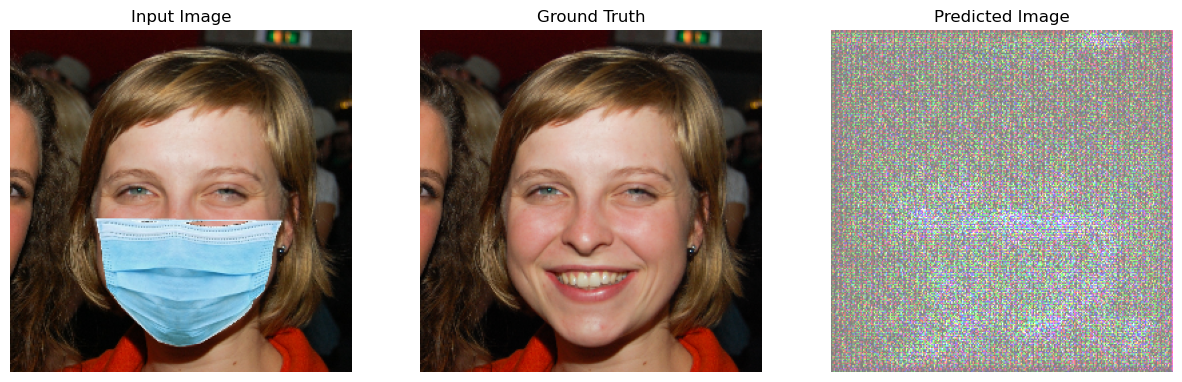

2024-10-27 14:17:32.107760: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Epoch 2/10
Ony Update G!


2024-10-27 14:17:46.549816: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-10-27 14:17:50.083966: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


  loss_total: 81.64724731445312 - loss_ssim: 0.9953193664550781 - loss_rec: 0.7789429426193237 - loss_discriminator: 2.1739394664764404
  val_loss: 81.63636016845703 - val_ssim: 0.9951454997062683 - val_rec: 0.7833737134933472 - val_Disc: 2.169344902038574
  Time taken: 17.98s

Epoch 3/10:
Update D!


2024-10-27 14:18:13.601513: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-10-27 14:18:16.929765: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


  loss_total: 81.61162567138672 - loss_ssim: 0.9948554039001465 - loss_rec: 0.7820496559143066 - loss_discriminator: 2.1694650650024414
  val_loss: 81.5007553100586 - val_ssim: 0.9938452839851379 - val_rec: 0.7762367129325867 - val_Disc: 2.123296022415161
  Time taken: 26.85s


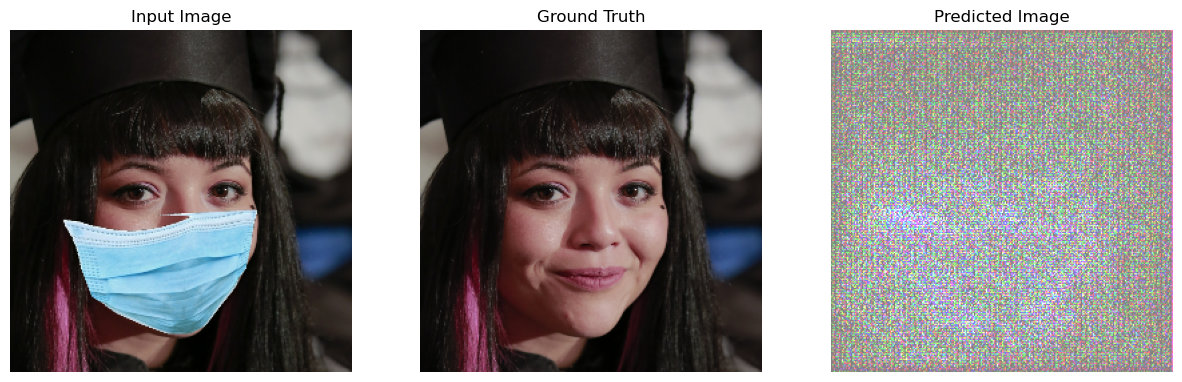

2024-10-27 14:18:21.229695: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Epoch 4/10
Ony Update G!


2024-10-27 14:18:35.595689: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-10-27 14:18:39.073780: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


  loss_total: 81.53854370117188 - loss_ssim: 0.9942264556884766 - loss_rec: 0.7827267050743103 - loss_discriminator: 2.1223034858703613
  val_loss: 81.4516830444336 - val_ssim: 0.9931607246398926 - val_rec: 0.7817457914352417 - val_Disc: 2.121453046798706
  Time taken: 17.84s

Epoch 5/10:
Update D!


2024-10-27 14:19:03.821408: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-10-27 14:19:07.202632: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


  loss_total: 81.4638671875 - loss_ssim: 0.9933353662490845 - loss_rec: 0.7814562916755676 - loss_discriminator: 2.118579149246216
  val_loss: 81.3641586303711 - val_ssim: 0.9923510551452637 - val_rec: 0.7806220650672913 - val_Disc: 2.078655958175659
  Time taken: 26.53s


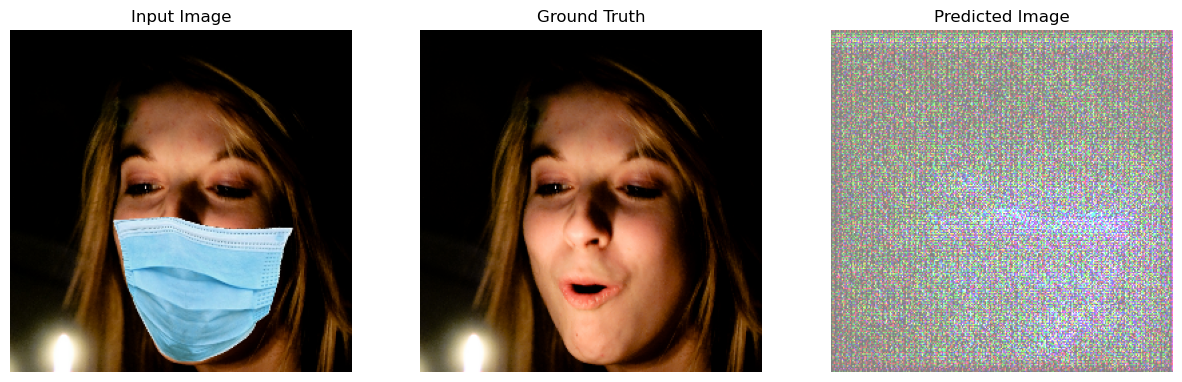

2024-10-27 14:19:11.385557: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Epoch 6/10
Ony Update G!


2024-10-27 14:19:25.673986: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-10-27 14:19:29.141463: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


  loss_total: 81.3281021118164 - loss_ssim: 0.9919623136520386 - loss_rec: 0.7742183804512024 - loss_discriminator: 2.0841009616851807
  val_loss: 81.34587097167969 - val_ssim: 0.992117702960968 - val_rec: 0.7801850438117981 - val_Disc: 2.080472946166992
  Time taken: 17.76s

Epoch 7/10:
Update D!


2024-10-27 14:19:52.857603: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-10-27 14:19:56.592552: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


  loss_total: 81.27727508544922 - loss_ssim: 0.9913427233695984 - loss_rec: 0.7744344472885132 - loss_discriminator: 2.0810694694519043
  val_loss: 81.32215881347656 - val_ssim: 0.9920647740364075 - val_rec: 0.7781021595001221 - val_Disc: 2.0465121269226074
  Time taken: 27.01s


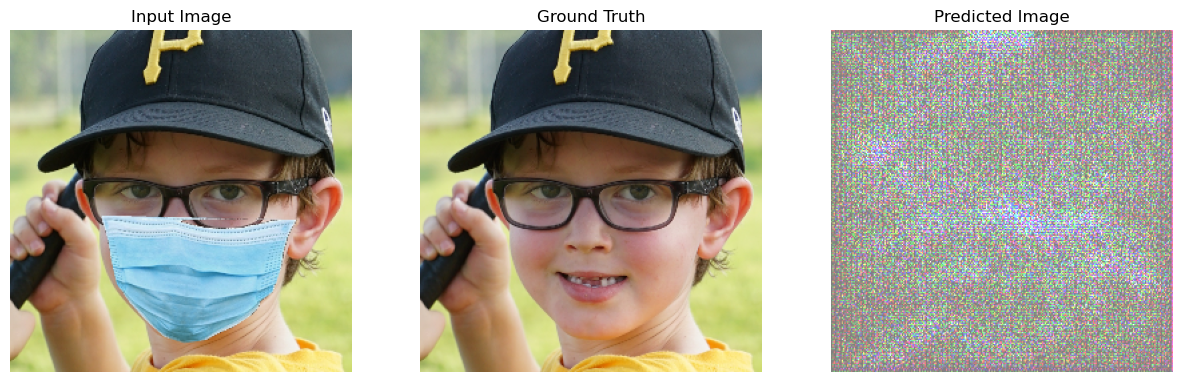

2024-10-27 14:20:00.325584: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Epoch 8/10
Ony Update G!


2024-10-27 14:20:14.839998: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-10-27 14:20:18.375051: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


  loss_total: 81.23096466064453 - loss_ssim: 0.9909418821334839 - loss_rec: 0.7791749835014343 - loss_discriminator: 2.0412116050720215
  val_loss: 81.1650619506836 - val_ssim: 0.9901684522628784 - val_rec: 0.7751147150993347 - val_Disc: 2.0428996086120605
  Time taken: 18.05s

Epoch 9/10:
Update D!


2024-10-27 14:20:42.089993: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-10-27 14:20:45.442271: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


  loss_total: 81.14968872070312 - loss_ssim: 0.9899855852127075 - loss_rec: 0.7739776372909546 - loss_discriminator: 2.0441360473632812
  val_loss: 81.1271743774414 - val_ssim: 0.9898697137832642 - val_rec: 0.7779564261436462 - val_Disc: 2.0080955028533936
  Time taken: 26.63s


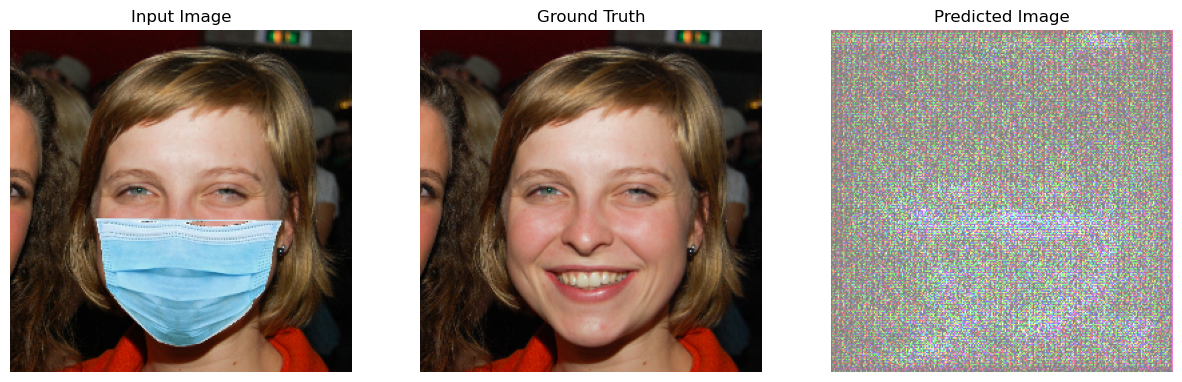

2024-10-27 14:20:51.541742: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Epoch 10/10
Ony Update G!


In [ ]:
epochs = 10
lambda_rec = 1.2
lambda_adv = 0.5
lambda_ssim = 80

num_epoch_update_D = 5

hyper_params={"lambda_rec": lambda_rec,
             "lambda_adv": lambda_adv,
             "lambda_ssim": lambda_ssim,}
model_gen, model_dis = model_fit(train_datasets, test_datasets, epochs, num_epoch_update_D, hyper_params)
model_gen.save('generator.h5')

## Test model

In [ ]:
status = generator.load_weights("generator.h5", by_name=True)
for input, target in test_datasets.take(1):
    generate_images(generator, input, target)